---
title: Nearest Neighbor Model
author: Andrei Akopian
date: 2025-11-22
format:
  html:
    code-fold: true
    code-summary: "Show the code"
  pdf:
    code-overflow: wrap
    echo: false
    output: true
---

In [3]:
import pandas as pd
# import plotly.express as px
import numpy as np
import spectral_library # * all major functions have been moved here
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy
from icecream import ic
import matplotlib as mpl

In [4]:
import importlib
importlib.reload(spectral_library)

<module 'spectral_library' from '/Users/andrei/Documents/Coding/Challenges/UTAT Onboarding/spectral_library.py'>

In [4]:
df = spectral_library.open_file('unmixing/original_data.csv')

In [5]:
fractions, nr900to1700, _ = spectral_library.take_subset(df,start=900,end=1700)

Separate finding, code for which I deleted at some point:
Reflectance magnitudes (neither sums nor Pythagorean magnitudes) correlate with npv_fractions (r^2=0.0X).

In [8]:
fractions, nr400to2490, _ = spectral_library.take_subset(df,start=700,end=2490)

In [112]:
samples = 1723
distances = np.load("intermediate_calculations/rf900to1700-original-euclidean-distances.npy")
distances_matrix = distances.reshape(samples,samples)

In [6]:
def get_closest_indexes(matrix,exclude_selfentries=True):
    modded_matrix = matrix
    if exclude_selfentries:
        modded_matrix = matrix.copy()
        for i in range(len(modded_matrix)):
            modded_matrix[i][i] = np.inf
    closest_indexes = [np.argmin(a) for a in modded_matrix]
    return closest_indexes

In [115]:
closest_indexes = get_closest_indexes(distances_matrix)

In [33]:
def simple_histogram(data=[1,2,3],title="Title",x="x-axis",y='y-axis',bins=10):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.hist(data,bins=bins)
    print()

In [9]:
# create list with indexes [((row,col),distance),...] format
indexed_distances = [
    sorted([
        (distances_matrix[j][i],i) for i in range(samples)
    ], key=lambda x: x[0]) for j in range(samples)
]

In [10]:
len(indexed_distances)

1723

In [1]:
i = 100
simple_histogram([v[0] for v in indexed_distances[i]],title=f"Distances to outer datapoints for sample {i}",x="Distance",y="Count",bins=40)

NameError: name 'simple_histogram' is not defined

In [12]:
def triangle_metric(a,b,c):
    return (a+b) / c

In [13]:
closest_triangles = [
    triangle_metric(
        indexed_distances[i][1][0],
        indexed_distances[i][2][0],
        distances_matrix[indexed_distances[i][1][1]][indexed_distances[i][2][1]]
    ) for i in range(samples)
]

/var/folders/8m/2xtf2jw17lb35znwjpyxlhhr0000gn/T/ipykernel_69883/2548215420.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (a+b) / c


In [14]:
closest_triangles.sort()

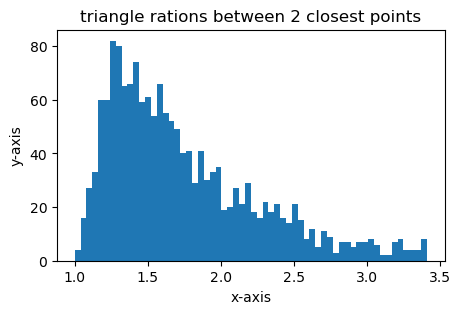

In [15]:
simple_histogram(closest_triangles[:-100],title="triangle rations between 2 closest points",bins=60)

## Base alg nearest neighbor at different Ks
Simple base algorithm which just averages k nearest neighbors works best at k between 3 and 8.

In [7]:
npv_fractions = fractions['npv_fraction'].to_list()
gv_fractions = fractions['gv_fraction'].to_list()
soil_fractions = fractions['soil_fraction'].to_list()

In [8]:
def generateknearestPredictions(k=5):
    predictions = [
        [sum([npv_fractions[v[1]] for v in indexed_distances[i][1:k+1]])/k,
        sum([gv_fractions[v[1]] for v in indexed_distances[i][1:k+1]])/k,
        sum([soil_fractions[v[1]] for v in indexed_distances[i][1:k+1]])/k]
        for i in range(samples)
    ]
    return predictions

def evaluate_model(predictions,actual):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(actual, predictions)
    return slope, intercept, r_value, p_value, std_err

In [31]:
def k_tuning(
        start_k = 1,
        end_k = 15,
        step = 1
    ):
    records = [
        [k, generateknearestPredictions(k)]
        for k in range(start_k,end_k,step)
    ]
    r2_records = [
        [r[0], [
                evaluate_model(
                    [
                        s[0]
                        for s in r[1]
                    ],
                    npv_fractions
                )[2]**2,
                evaluate_model(
                    [
                        s[1]
                        for s in r[1]
                    ],
                    gv_fractions
                )[2]**2,
                evaluate_model(
                    [
                        s[2]
                        for s in r[1]
                    ],
                    soil_fractions
                )[2]**2
            ]
        ] for r in records
    ]
    return r2_records

In [32]:
def model_parameter_chart(parameter,value,title="Parameter - Model chart",x="Parameter",y="Value"):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.plot(parameter, value)
    ax.legend(['npv', 'gv', 'soil'])
    print()

### KNN Parameter Tuning
Best performance clearly around k = 3 to 6.
The validation I am doing here is a bit sketchy though.

In [33]:
r2_records = k_tuning()

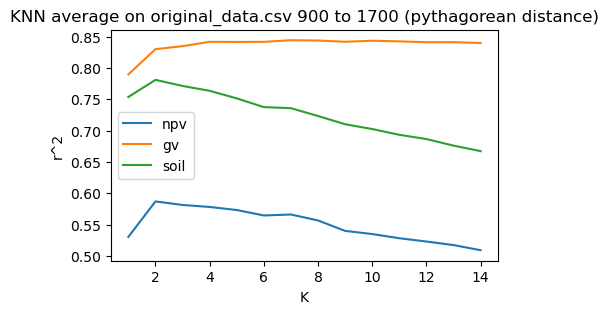

In [34]:
model_parameter_chart(
    parameter=[r[0] for r in r2_records], # k
    value=[r[1] for r in r2_records], # fractions
    x="K",
    y="r^2",
    title="KNN average on original_data.csv 900 to 1700 (pythagorean distance)"
)

### KNN Metrics
I hope to improve these results, by improving my weighting algorithms.

In [100]:
for i,ids in enumerate(indexed_distances):
    if 0 in [v[0] for v in ids[1:10]]:
        ic(i,ids[1:10])

ic| i: 517
    ids[1:10]: [(np.float64(0.0), 524),
                (np.float64(0.033502759971139134), 523),
                (np.float64(0.03580537876068145), 531),
                (np.float64(0.05673890081203861), 521),
                (np.float64(0.05745686600025439), 522),
                (np.float64(0.06394786338490398), 519),
                (np.float64(0.0653029394909623), 1060),
                (np.float64(0.06624769171635166), 534),
                (np.float64(0.06772827020054106), 525)]
ic| i: 524
    ids[1:10]: [(np.float64(0.0), 524),
                (np.float64(0.033502759971139134), 523),
                (np.float64(0.03580537876068145), 531),
                (np.float64(0.05673890081203861), 521),
                (np.float64(0.05745686600025439), 522),
                (np.float64(0.06394786338490398), 519),
                (np.float64(0.0653029394909623), 1060),
                (np.float64(0.06624769171635166), 534),
                (np.float64(0.06772827020054106), 525)]


In [18]:
def average(lookup_list, indexed_distances, k, i):
    return (
        sum([lookup_list[v[1]]/v[0] for v in indexed_distances[i][2:k+1]]) /
        sum([1/v[0] for v in indexed_distances[i][2:k+1]])
    )
def generateKNNPredictionsByAlg(k=5,algorithm=average):
    predictions = [
        [algorithm(npv_fractions,indexed_distances,k,i) for i in range(samples)],
        [algorithm(gv_fractions,indexed_distances,k,i) for i in range(samples)],
        [algorithm(soil_fractions,indexed_distances,k,i) for i in range(samples)]
    ]
    return predictions

In [19]:
predictions = generateKNNPredictionsByAlg(k=7)
ic(spectral_library.evaluate_model(predictions[0], npv_fractions)[0])
ic(spectral_library.evaluate_model(predictions[1], gv_fractions)[0])
ic(spectral_library.evaluate_model(predictions[2], soil_fractions)[0])

ic| spectral_library.evaluate_model(predictions[0], npv_fractions)[0]: np.float64(0.5249181205275544)
ic| spectral_library.evaluate_model(predictions[1], gv_fractions)[0]: np.float64(0.8333401967155695)
ic| spectral_library.evaluate_model(predictions[2], soil_fractions)[0]: np.float64(0.7050063732961683)


np.float64(0.7050063732961683)

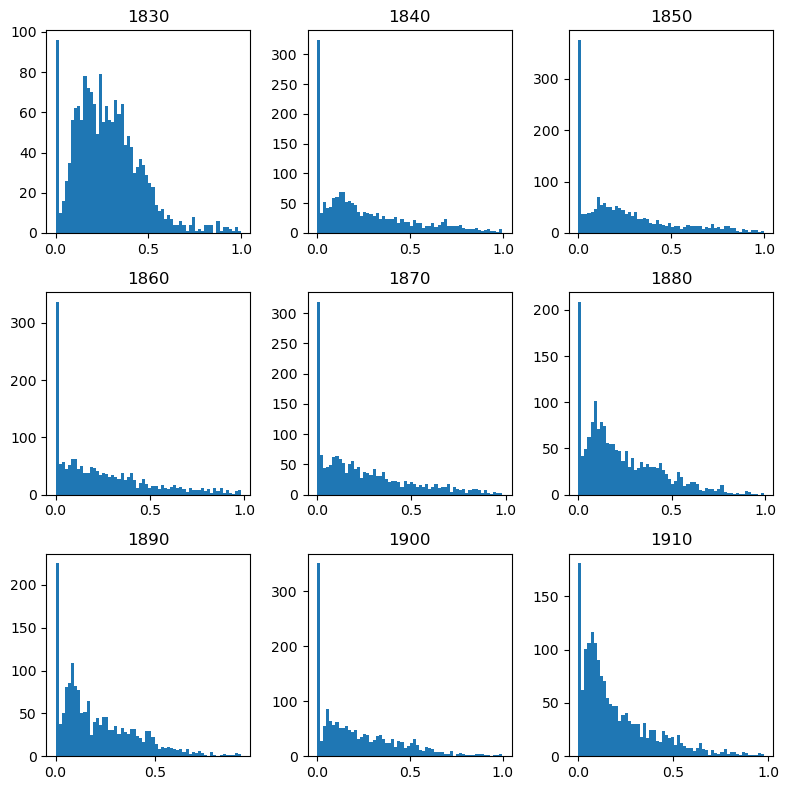

In [15]:
# Create a 2x2 grid of subplots
spectra = ["1830","1840","1850","1860","1870","1880","1890","1900","1910"]
n_plots = len(spectra)
row = int(np.ceil(np.sqrt(n_plots)))
fig, axs = plt.subplots(row, row, figsize=(8, 8))

for i, s in enumerate(spectra):
    px = i % row 
    py = i // row
    axs[py, px].hist(nr400to2490[s],bins=60)
    axs[py, px].set_title(s)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

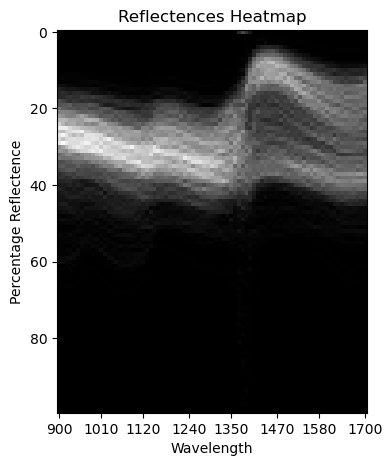

In [ ]:
fig, ax = plt.subplots(figsize=(4, 200))

yticks = nr900to1700.columns

resolution = 100
bins = [1/resolution*i for i in range(0,resolution+1)]
l = [np.histogram(nr900to1700[s], bins=bins)[0] for s in yticks]
np_formatted_l = np.rot90(np.fliplr(np.vstack(l)))

ax.imshow(np_formatted_l, vmin=0, cmap='gray')

ax.set_title("Reflectences Heatmap")
ax.set_xlabel("Wavelength")
ax.set_ylabel("Percentage Reflectence")
n_ticks = 8
idx = np.linspace(0, len(yticks)-1, n_ticks, dtype=int)
ticks = yticks[idx]
plt.xticks(idx, ticks)  

plt.show()

In [5]:
def createHeatmap(nrAtoB):
    fig, ax = plt.subplots(1, 3, figsize=(20, 14))

    yticks = nrAtoB.columns

    resolution = 100
    bins = [1/resolution*i for i in range(0,resolution+1)]
    npv_fractions = fractions['npv_fraction'].to_numpy()

    l = [np.histogram(nrAtoB[s], bins=bins)[0] for s in yticks]
    normal_l = np.rot90(np.fliplr(np.vstack(l)))
    ax[0].imshow(normal_l,vmin=0,cmap='gray')
    ax[0].set_title("normal heatmap")
    ax[0].set_xlabel("Wavelength")
    ax[0].set_ylabel("Percentage Reflectence")

    wl = [np.histogram(nrAtoB[s], bins=bins, weights=npv_fractions)[0] for s in yticks]
    weighted_l = np.rot90(np.fliplr(np.vstack(wl)))
    ax[1].imshow(weighted_l,cmap='gray')
    ax[1].set_title("npv weighted heatmap")
    ax[1].set_xlabel("Wavelength")

    wl_max = np.max(wl)
    l_max = np.max(l)
    diff_l = weighted_l/wl_max - normal_l/l_max
    diff_plot = ax[2].imshow(diff_l, vmin=-0.25, vmax=0.25, cmap='coolwarm')
    ax[2].set_title("diff heatmap (weighted - normal)")
    ax[2].set_xlabel("Wavelength")
    fig.colorbar(diff_plot, shrink=0.3, orientation='vertical')

    n_ticks = 6
    idx = np.linspace(0, len(yticks)-1, n_ticks, dtype=int)
    ticks = yticks[idx]
    ax[0].set_xticks(idx, ticks)  
    ax[1].set_xticks(idx, ticks)
    ax[2].set_xticks(idx, ticks)

    plt.show()

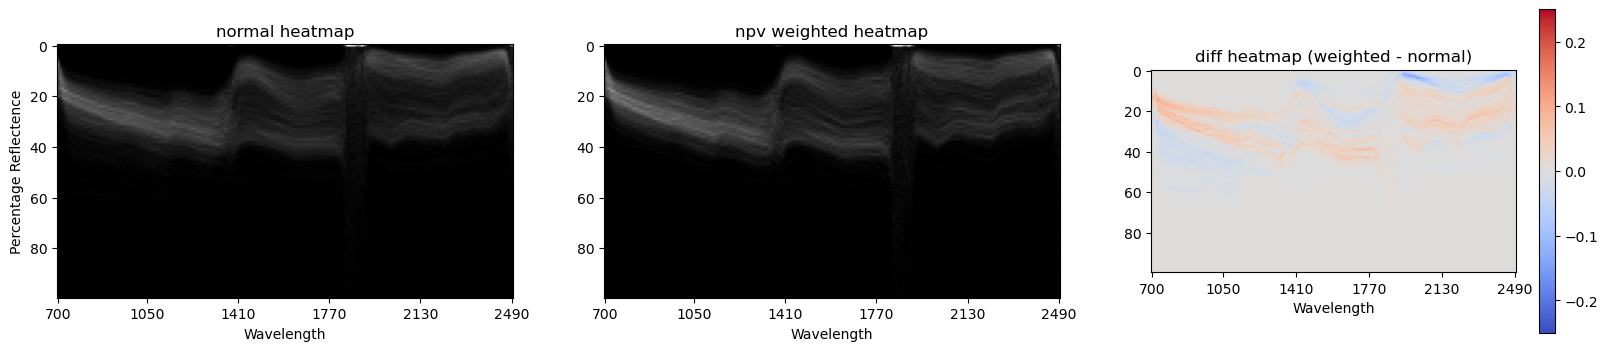

In [6]:
createHeatmap(nr400to2490)

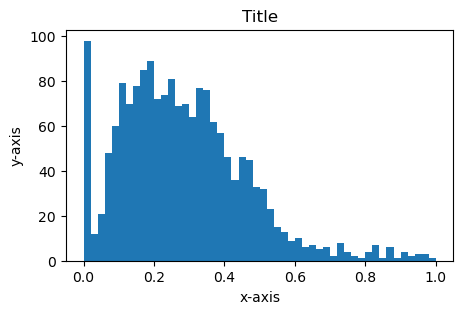

In [13]:
# columns = yticks.to_list()
simple_histogram(nr400to2490["1830"],bins=50)
# simple_histogram(nr400to2490[""],bins=50)
# simple_histogram(nr400to2490["1400"],bins=50)

In [23]:
mins = [nr400to2490.iloc[i].min() for i in range(nr400to2490.shape[0])]

In [ ]:
indecies_affected = [i for i in range(nr400to2490.shape[0]) if nr400to2490.iloc[i].min()<0.0001]

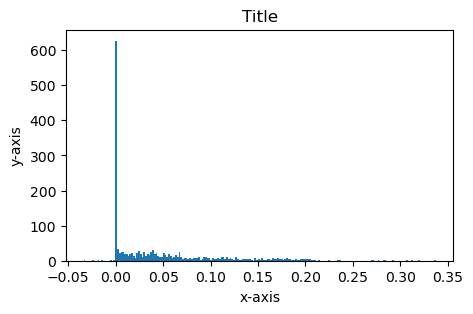

In [36]:
simple_histogram(mins, bins=200)

In [48]:
sorted(mins)[610]

np.float64(0.0008431296)

In [14]:
sums = [fractions.iloc[i].sum() for i in range(nr400to2490.shape[0])]

In [58]:
affected = fractions.loc[indecies_affected]

In [59]:
affected.shape

(550, 3)

In [18]:
import mpltern
import matplotlib as mpl

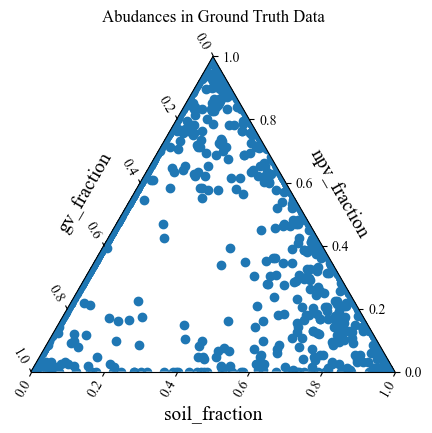

In [41]:
mpl.rcParams['font.family'] = ['Times New Roman']

fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)
ax = fig.add_subplot(1, 2, 1, projection="ternary")
pc = ax.scatter(fractions['npv_fraction'],fractions['gv_fraction'],fractions['soil_fraction'])

# ax.left_axis_label("npv_fraction", fontsize=12, offset=0.1)
# ax.right_axis_label("gv_fraction", fontsize=12, offset=0.1)
# ax.bottom_axis_label("soil_fraction", fontsize=12, offset=0.1)


position = 'tick1'
ax.set_tlabel('npv_fraction', fontsize=14)
ax.set_llabel('gv_fraction', fontsize=14)
ax.set_rlabel('soil_fraction', fontsize=14)

ax.taxis.set_label_position(position)
ax.laxis.set_label_position(position)
ax.raxis.set_label_position(position)

t_text = ax.taxis.label
l_text = ax.laxis.label
r_text = ax.raxis.label

ax.set_title('Abudances in Ground Truth Data')
plt.savefig("outputs/ternary_plot.svg", format="svg")
plt.show()

NameError: name 'affected' is not defined

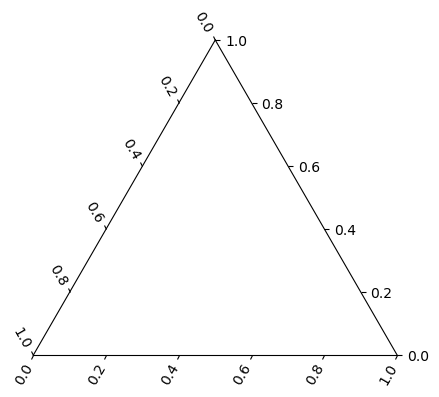

In [7]:
fig = plt.figure(figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)
ax = fig.add_subplot(1, 2, 1, projection="ternary")
pc = ax.scatter(affected['npv_fraction'],affected['gv_fraction'],affected['soil_fraction'])
ax.set_tlabel('npv_fraction')
ax.set_llabel('gv_fraction')
ax.set_rlabel('soil_fraction')
ax.set_title('Points with anomalies')
plt.show()

## Externality Metrics

How central or not-central a datapoint is.

### Ideas

Spearman rank sort of approach, where for each wavelength, the values are sorted and the ranks are recorded.
- problem: produces unclear distributions per element
  
Generic z score methods:
- problem: binomial distribution



In [9]:
columns = nr900to1700.columns
orders = []
for column in columns:
    orders.append(
        nr900to1700.sort_values(by=column).index.to_list()
    )
index_orders = []
for i in range(samples):
    indexes = []
    for order in orders:
        indexes.append(
            order.index(i)
        )
    index_orders.append(indexes)

In [ ]:
def externality_metric1(index_order): # absolute from mean
    n = len(index_order)
    mean = n/2
    metric = sum([abs((i-mean)/n) for i in index_order])/n
    return metric
def externality_metric2(index_order): # squared from mean
    n = len(index_order)
    mean = n/2
    metric = sum([((i-mean)/n)**2 for i in index_order])/n
    return metric
def externality_metric2(index_order): # z-score
    n = len(index_order)
    mean = n/2
    metric = sum([((i-mean)/n)**2 for i in index_order])/n
    return metric

In [67]:
externality_scores = [externality_metric2(i) for i in index_orders]


Min: 0.08721993598536809, Max: 424.180577430044


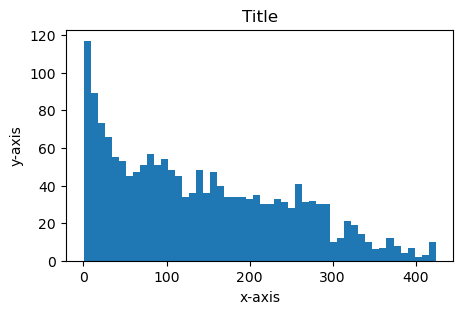

In [68]:
simple_histogram(externality_scores,bins=50)
print(f"Min: {min(externality_scores)}, Max: {max(externality_scores)}")

In [69]:
sorted_externality_scores = sorted([(i,score) for i,score in enumerate(externality_scores)],key=lambda x: x[1],reverse=True)

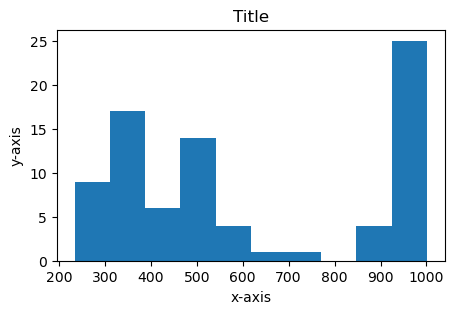

In [79]:
simple_histogram(index_orders[10])

### Z-score Outlier Metric


In [14]:
nr900to1700['1000'].to_numpy().std()

np.float64(0.07168216769809693)

In [18]:
columns = nr900to1700.columns
mean = []
std_sigma = []
for column in columns:
    nr_column = nr900to1700[column]
    mean.append(nr_column.mean())
    std_sigma.append(nr_column.std())

In [19]:
z_scores_matrix = [
    [
        (point-mean[i])/std_sigma[i]
        for point in nr900to1700[column]
    ]
    for i, column in enumerate(nr900to1700.columns)
]

In [ ]:
z_score_externalities = [
    (sum([
        z_scores_matrix[w][i]**2
        for w in range(len(nr900to1700.columns))
    ])/len(nr900to1700.columns))**(1/2) # the distance from mean
    for i in range(samples)
]

In [32]:
sorted_externality_scores = sorted([(i,score) for i,score in enumerate(z_score_externalities)],key=lambda x: x[1],reverse=True)

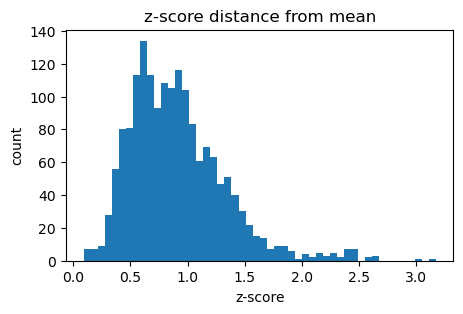

In [27]:
simple_histogram(z_score_externalities, title='z-score distance from mean', x='z-score', y='count', bins=50)

## Correlation Tests with Residuals

In [51]:
train_X, validate_X, train_y, validate_y = sklearn.model_selection.train_test_split(nr900to1700, fractions, test_size=0.2, random_state=42)

In [64]:
rf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=18,
    max_features = 13,
    min_samples_split=3,
    min_samples_leaf=1,
    min_impurity_decrease=0.0,
    min_weight_fraction_leaf=0.0,
    random_state = 42,
) # best rf model I have
rf.fit(train_X,train_y)

,n_estimators,200
,criterion,'squared_error'
,max_depth,18
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
#| code-summary: "Random Forest Validation"
predicted = rf.predict(validate_X)
predicted_npv = np.fromiter((p[0] for p in predicted), float)
# plot = sns.scatterplot(x=predicted_npv,y=validate_y['npv_fraction'].to_list())
# plot.set_xlabel("Predicted")
# plot.set_ylabel("Actual")
# plot.set_title("Predicted by RandomForest vs Actual on Validation")
print("Training R^2:",rf.score(train_X,train_y))
print("Validation R^2:",rf.score(validate_X,validate_y))

NameError: name 'rf' is not defined

In [57]:
to_drop = [d[0] for d in sorted_externality_scores[0:200] if d[0] in validate_X.index]
print(to_drop)
dropped_vX = validate_X.drop(to_drop)
dropped_vY = validate_y.drop(to_drop)

[1168, 300, 210, 297, 212, 1440, 985, 350, 1100, 298, 942, 188, 962, 1565, 1189, 365, 857, 1713, 940, 237, 1610, 316, 964, 374, 721, 259, 175, 808, 925, 1005, 141, 250, 1157, 792, 1448, 921, 680, 1378, 1640, 939, 1376]


In [ ]:
lm = spectral_library.train_linear_model(train_X,train_y)
print("Original")
spectral_library.validate(lm, train_X, validate_X, train_y, validate_y) # original
print("Dropped")
spectral_library.validate(lm, train_X, dropped_vX, train_y, dropped_vY) # dropped

Training R^2: 0.845
Original
Training R^2: 0.845
Validation R^2: 0.8151
Dropped
Training R^2: 0.845
Validation R^2: 0.8268


In [65]:
rf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=18,
    max_features = 13,
    min_samples_split=3,
    min_samples_leaf=1,
    min_impurity_decrease=0.0,
    min_weight_fraction_leaf=0.0,
    random_state = 42,
) # best rf model I have
rf.fit(nr900to1700,fractions)

,n_estimators,200
,criterion,'squared_error'
,max_depth,18
,min_samples_split,3
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [74]:
lm = spectral_library.train_linear_model(nr900to1700,fractions)

Training R^2: 0.841


In [93]:
# not full data, and check only effect on training
to_drop = [d[0] for d in sorted_externality_scores[-300:]]
dropped_tX = nr900to1700.drop(to_drop)
dropped_tY = fractions.drop(to_drop)

In [94]:
print("== RF ==")
print("R^2 after dropping potential outliers", rf.score(nr900to1700, fractions))
print("R^2 after dropping potential outliers", rf.score(dropped_tX, dropped_tY))
print("== Linear Regression ==")
print("R^2 after dropping potential outliers", lm.score(nr900to1700, fractions))
print("R^2 after dropping potential outliers", lm.score(dropped_tX, dropped_tY))

== RF ==
R^2 after dropping potential outliers 0.9639557867392834
R^2 after dropping potential outliers 0.9662354257248781
== Linear Regression ==
R^2 after dropping potential outliers 0.8410484268254907
R^2 after dropping potential outliers 0.8425169627064076


In [95]:
residuals = validate_y-lm.predict(validate_X)
residuals['sum'] = residuals.abs().sum(axis=1)

In [96]:
sorted_residuals = residuals.sort_values(by='sum')

In [101]:
sorted_residuals.tail(10)

,npv_fraction,gv_fraction,soil_fraction,sum
1128,0.279028,0.084775,-0.363808,0.727612
188,0.207485,0.160092,-0.367578,0.735154
162,0.362190,0.005406,-0.367609,0.735206
365,-0.373103,0.047532,0.325569,0.746203
316,-0.178124,-0.209195,0.387317,0.774636
1100,-0.318827,-0.126564,0.445384,0.890776
141,0.446900,-0.202437,-0.244457,0.893795
109,0.479998,-0.181267,-0.298725,0.959990
247,0.535229,-0.039374,-0.495882,1.070485
324,-0.057484,-0.604713,0.662210,1.324407


In [111]:
z_score_externalities[1128]

np.float64(0.4685711980327913)

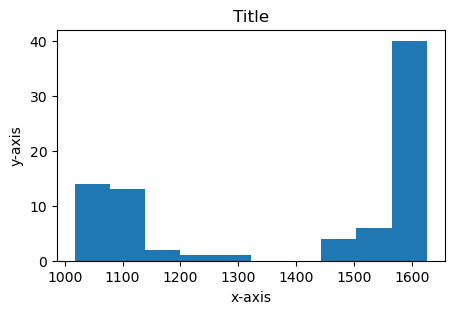

In [121]:
simple_histogram(index_orders[342])

In [61]:
npv_fractions = validate_y['npv_fraction'].to_list()
npv_residuals = [abs(predicted_npv[i]-npv_fractions[i]) for i in range(len(predicted_npv))]
externality_scores_validationsubset = [externality_scores[validate_X.iloc[i].name] for i in range(len(validate_X))]
print(spectral_library.evaluate_model(externality_scores_validationsubset,npv_residuals))

(np.float64(0.009066355020346065), (np.float64(-4.190777270265147), np.float64(10.35484802031445), np.float64(-0.09521740922933193), np.float64(0.0773654753457382), np.float64(2.3656660986301596)))


### Use KNN to exclude points far away


In [ ]:
closest_indexes = get_closest_indexes(distances_matrix)

In [119]:
sorted_externality_scores = sorted([(i, distances_matrix[i][closest_indexes[i]]) for i in range(samples)],key=lambda x: x[1],reverse=True)

In [127]:
# not full data, and check only effect on training
to_drop = [d[0] for d in sorted_externality_scores[:600]]
dropped_tX = nr900to1700.drop(to_drop)
dropped_tY = fractions.drop(to_drop)

In [129]:
print("== RF ==")
print("R^2 after dropping potential outliers", rf.score(nr900to1700, fractions))
print("R^2 after dropping potential outliers", rf.score(dropped_tX, dropped_tY))
print("== Linear Regression ==")
print("R^2 after dropping potential outliers", lm.score(nr900to1700, fractions))
print("R^2 after dropping potential outliers", lm.score(dropped_tX, dropped_tY))

== RF ==
R^2 after dropping potential outliers 0.9639557867392834
R^2 after dropping potential outliers 0.9656038897465021
== Linear Regression ==
R^2 after dropping potential outliers 0.8410484268254907
R^2 after dropping potential outliers 0.844486892378033
